In [21]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import mysql.connector


In [22]:
np.random.seed(500)

In [23]:
#Import the review dataset
def getDataset(n=10000):
    connection = mysql.connector.connect(
                host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
                database='ds50',
                user='ds50',
                password='AVNS_4ybSd0CoPKnCL5F',
                port = '25060'
    )

    for i in range(6):

        query = f"""
            SELECT
                *
            FROM
                REVIEW
            WHERE
                rating = {i}
            AND
                review_text != ''
            LIMIT
                {n//5}
        """

        if connection.is_connected():
            if not i:
                df = pd.read_sql(query, connection)
            else:
                new_df = pd.read_sql(query, connection)
                df = pd.concat([df, new_df])
    return df

In [24]:
data = getDataset()


C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas

In [25]:
data = data[(data['review_text'].str.len() > 3) & (data['review_text'].str.len() < 3000) & (((~ data['review_text'].str.isdigit()) & (data['review_text'].str.len() != 0)) | (data['rating'] != 0))]


In [26]:
data.shape
data = data.reset_index()
data = data.drop(columns=["index"])
data.head(15)

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,00020adeea578404ffa05e295fb2b182,253237,18966322,0,"I am interested in this world, but the series ...",2014-01-10 07:41:32,NaT,0,0
1,0007d6eff54a2588045d2b51a29a59bd,126657,9659607,0,The Iron Fey series is definitely one of my mo...,2011-10-09 03:27:18,2011-10-08 07:00:00,1,0
2,00099c8e53d5f8d41aad970d964179a5,60325,2536134,0,The niece picked this out herself at the libra...,2015-09-05 22:20:08,NaT,1,1
3,000f20f9182eee32cfb0f58dd9dce4f2,35934,19540434,0,We are so excited to celebrate the release of ...,2014-09-20 19:39:15,NaT,0,0
4,0010089a92b151283e08ba8699ef6469,39985,11990677,0,"Very entertaining, as expected. The great writ...",2012-03-04 19:14:07,2012-03-04 08:00:00,0,0
5,001a9d3669e0976c58503cdc6f8ac72f,58851,17164644,0,Freaking amazing!! Loveddddd ittttt!!! Couldn'...,2013-08-05 04:49:57,NaT,0,0
6,001aa1261ffbe1345d5f2daf7e34dcd5,126657,18081228,0,After having The Orphan Queen sitting on my sh...,2016-04-04 23:02:15,2016-04-04 07:00:00,0,0
7,001cd042979633aec23c3c8ffc483cc1,4145,3720975,0,Pretty good book but a very emotionally wrench...,2008-08-11 18:05:03,2016-07-29 07:00:00,0,0
8,001dbca332f7267bb9cfd701007c89d6,173626,22749796,0,Couldn't read.,2016-08-30 23:19:09,2016-08-30 07:00:00,0,0
9,001e0c38fb23aa53bc3f70f1ba37b842,396466,51738,0,i lik annabel character..,2011-12-30 10:11:24,2011-12-30 08:00:00,0,0


In [27]:
#On supprime les ligne de commentaire vide
data['review_text'].dropna(inplace=True)

#On met tout en minuscule
data['review_text'] = [entry.lower() for entry in data['review_text']]

data['review_text'] = [word_tokenize(entry) for entry in data['review_text']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(data['review_text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    data.loc[index,'review_text'] = str(Final_words)

In [28]:

data[data['rating'] == 0].head()

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,00020adeea578404ffa05e295fb2b182,253237,18966322,0,"['interested', 'world', 'series', 'ya', 'sligh...",2014-01-10 07:41:32,NaT,0,0
1,0007d6eff54a2588045d2b51a29a59bd,126657,9659607,0,"['iron', 'fey', 'series', 'definitely', 'one',...",2011-10-09 03:27:18,2011-10-08 07:00:00,1,0
2,00099c8e53d5f8d41aad970d964179a5,60325,2536134,0,"['niece', 'pick', 'library', 'pull', 'goodread...",2015-09-05 22:20:08,NaT,1,1
3,000f20f9182eee32cfb0f58dd9dce4f2,35934,19540434,0,"['excited', 'celebrate', 'release', 'unforgive...",2014-09-20 19:39:15,NaT,0,0
4,0010089a92b151283e08ba8699ef6469,39985,11990677,0,"['entertaining', 'expect', 'great', 'writing',...",2012-03-04 19:14:07,2012-03-04 08:00:00,0,0


**Ratings count**

In [29]:
#création du jeu de donnée sans les zéros
datasans0 = data[data['rating'] != 0]

In [30]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(datasans0['review_text'],datasans0['rating'],test_size=0.3)

In [31]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
print(type(Test_X))

<class 'pandas.core.series.Series'>


In [32]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['review_text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [33]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracyb
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  43.624393624393626


In [34]:
#Create our own metrics to evaluate our models
def getAccuracyM1(y_test, y_pred):
    diff = abs(y_test-y_pred)
    return (diff < 2).sum()/len(diff)

Score: 0.8087318087318087


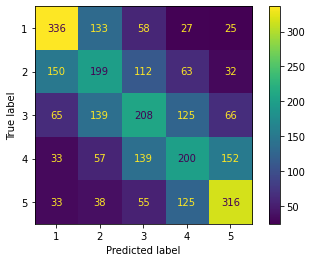

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Score: '+str(getAccuracyM1(Test_Y, predictions_SVM)))
cm = confusion_matrix(Test_Y, predictions_SVM)
CM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
CM.plot()
plt.grid(False)
plt.show()



On voit que la précision est de 45% ce qui est plutôt bon !!

In [36]:
Test_X_Tfidf = Tfidf_vect.transform(data[data['rating'] == 0]['review_text'])
predictions_sentiment_SVM = SVM.predict(Test_X_Tfidf)

k = 0
print(predictions_sentiment_SVM)

for i in range(len(data)):
    if data.loc[i,'rating'] == 0:
        if(predictions_sentiment_SVM[k] == 0):
            data.loc[i,'rating'] = 1
        else:
            data.loc[i,'rating'] = predictions_sentiment_SVM[k]
        k += 1
        

[0 4 0 ... 2 2 0]


In [37]:
data[data['rating'] == 0]

,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
